In [1]:
NAME = "models_experiments_2"

# NN vs. MATLAB

In [2]:
import jax
import jax.numpy as jnp
import numpy as np

import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath("./")))))

from loss import model
from jaxmeta.data import load_params, tensor_grid
from jaxmeta.loss import rmse

import config
from run_experiments_2 import n_ib, n_c
from data import domain

from scipy.io import loadmat
data_true = loadmat("epsilon_1e-12_fine_mesh_snapshots.mat")
u_true, v_true, x_test, t_test = data_true["u_snapshots"], data_true["v_snapshots"], data_true["x"], data_true["t"].T
xt_test = [tensor_grid([x_test, t_test_i]) for t_test_i in t_test]

# error at final time
errors = np.zeros((len(n_ib), len(n_c), 2))
for i, b in enumerate(n_ib):
	for j, c in enumerate(n_c):
		path = "{}/ib_{}_c_{}/iteration_{}/params.npy".format(NAME, i, j, config.iterations)
		params = load_params(path)
		uv_pred = model(params, xt_test[-1])
		errors[i, j, 0] = rmse(u_true[:, -1:], uv_pred[:, 0:1])
		errors[i, j, 1] = rmse(v_true[:, -1:], uv_pred[:, 1:2])

<IPython.core.display.Javascript object>


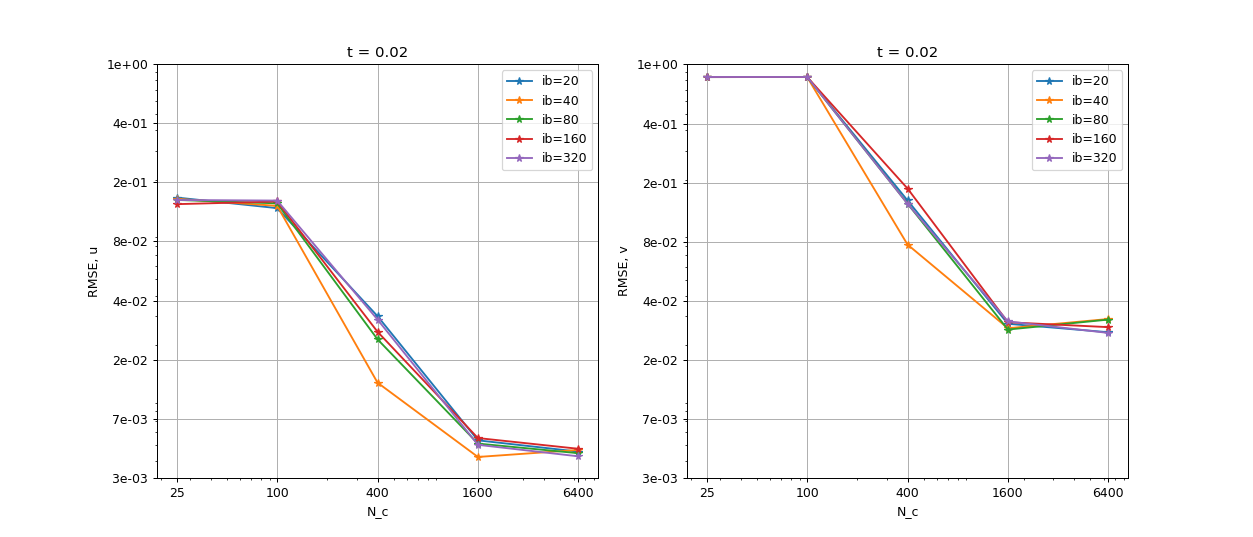

In [6]:
# print(errors)
import matplotlib.pyplot as plt
%matplotlib notebook

f, ax = plt.subplots(1, 2, figsize = (14, 6))

n_c_ = [c["cx"]*c["ct"] for c in n_c]
for i, b in enumerate(n_ib):
	ax[0].loglog(n_c_, errors[i, :, 0], "-*", label = "ib={}".format(b["i"]+b["b"]))
	ax[1].loglog(n_c_, errors[i, :, 1], "-*", label = "ib={}".format(b["i"]+b["b"]))

for ax_ in ax:
	ax_.set_xlabel("N_c")
	ax_.set_title("t = {:.2f}".format(t_test[-1][0]))
	ax_.set_xticks(n_c_)
	ax_.set_xticklabels(n_c_)
	yticks = [10**i for i in np.linspace(-2.5, -0, 8)]
	ax_.set_yticks(yticks)
	ax_.set_yticklabels(["{:.0e}".format(x) for x in yticks])
	ax_.legend()
	ax_.grid()
ax[0].set_ylabel("RMSE, u")
ax[1].set_ylabel("RMSE, v")
plt.show()

In [7]:
ib_candid = [1, 4]
c_candid = [1, 2, 3, 4]
t_candid = range(0, len(t_test), 120)

errors = np.zeros((len(ib_candid), len(c_candid), len(t_candid), 2))
for i, ib in enumerate(ib_candid):
	for j, c in enumerate(c_candid):
		path = "{}/ib_{}_c_{}/iteration_{}/params.npy".format(NAME, ib, c, config.iterations)
		params = load_params(path)
		for k, t in enumerate(t_candid):
			uv_pred = model(params, xt_test[t])
			errors[i, j, k, 0] = rmse(uv_pred[:, 0:1], u_true[:, t:t+1])
			errors[i, j, k, 1] = rmse(uv_pred[:, 1:2], v_true[:, t:t+1])

<IPython.core.display.Javascript object>


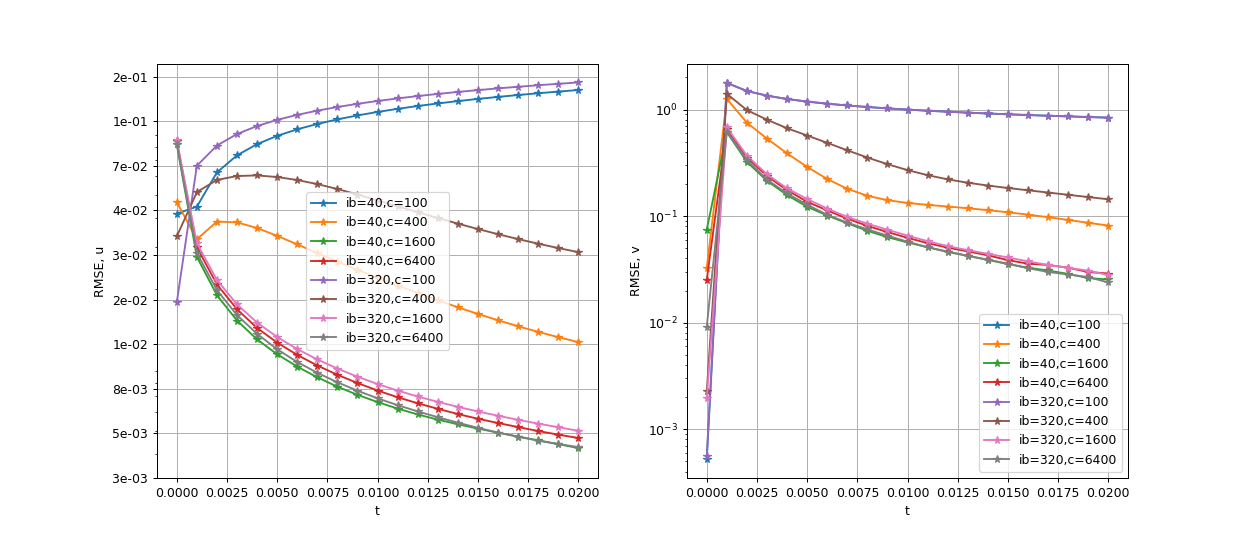

In [9]:
# print(errors)
import matplotlib.pyplot as plt
%matplotlib notebook

f, ax = plt.subplots(1, 2, figsize = (14, 6))

for i, b in enumerate(ib_candid):
	for j, c in enumerate(c_candid):
		ax[0].semilogy(t_test[t_candid], errors[i, j, :, 0], "-*", label = "ib={},c={}".format(n_ib[b]["i"]+n_ib[b]["b"], n_c[c]["cx"]*n_c[c]["ct"]))
		ax[1].semilogy(t_test[t_candid], errors[i, j, :, 1], "-*", label = "ib={},c={}".format(n_ib[b]["i"]+n_ib[b]["b"], n_c[c]["cx"]*n_c[c]["ct"]))

for ax_ in ax:
	ax_.set_xlabel("t")
	ax_.legend()
	ax_.grid()

yticks = [10**i for i in np.linspace(-2.5, -0.8, 10)]
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(["{:.0e}".format(x) for x in yticks])
ax[0].set_ylabel("RMSE, u")
ax[1].set_ylabel("RMSE, v")
plt.show()

- compare matlab solution w.r.t. analytic error
- compare NN solution w.r.t. analytic error
- inverse problem: use analytic solution as true data

# NN vs. Analytic

In [10]:
from scipy.special import erf
a = 1.0
u_fn = lambda x, t: 1.5 - 0.5*erf(x/np.sqrt(4*a*t))
u_analytic = [u_fn(xt[:, 0:1], xt[:, 1:2]) for xt in xt_test[1:]]

# error at final time
errors = np.zeros((len(n_ib), len(n_c)))
for i, b in enumerate(n_ib):
	for j, c in enumerate(n_c):
		path = "{}/ib_{}_c_{}/iteration_{}/params.npy".format(NAME, i, j, config.iterations)
		params = load_params(path)
		uv_pred = model(params, xt_test[-1])
		errors[i, j] = rmse(u_analytic[-1], uv_pred[:, 0:1])

<IPython.core.display.Javascript object>


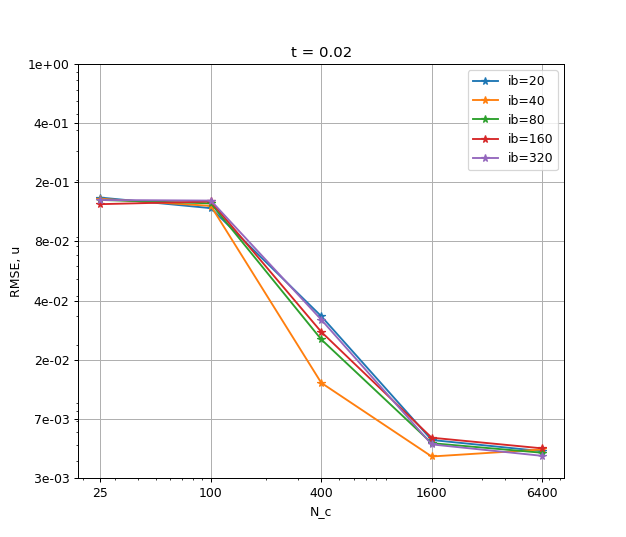

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook

f, ax = plt.subplots(1, 1, figsize = (7, 6))

n_c_ = [c["cx"]*c["ct"] for c in n_c]
for i, b in enumerate(n_ib):
	ax.loglog(n_c_, errors[i, :], "-*", label = "ib={}".format(b["i"]+b["b"]))

ax.set_xlabel("N_c")
ax.set_title("t = {:.2f}".format(t_test[-1][0]))
ax.set_xticks(n_c_)
ax.set_xticklabels(n_c_)
yticks = [10**i for i in np.linspace(-2.5, -0, 8)]
ax.set_yticks(yticks)
ax.set_yticklabels(["{:.0e}".format(x) for x in yticks])
ax.legend()
ax.grid()
ax.set_ylabel("RMSE, u")
plt.show()

In [13]:
ib_candid = [1, 4]
c_candid = [1, 2, 3, 4]
t_candid = range(1, len(t_test), 120)

errors = np.zeros((len(ib_candid), len(c_candid), len(t_candid)))
for i, ib in enumerate(ib_candid):
	for j, c in enumerate(c_candid):
		path = "{}/ib_{}_c_{}/iteration_{}/params.npy".format(NAME, ib, c, config.iterations)
		params = load_params(path)
		for k, t in enumerate(t_candid):
			uv_pred = model(params, xt_test[t])
			errors[i, j, k] = rmse(uv_pred[:, 0:1], u_analytic[t])

<IPython.core.display.Javascript object>


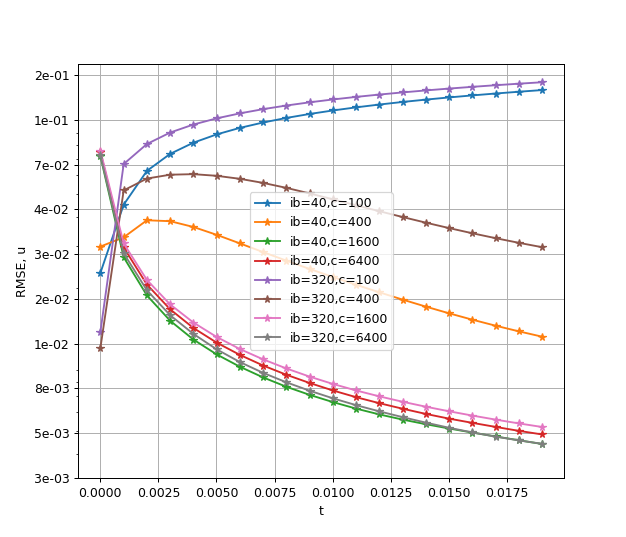

In [14]:
# print(errors)
import matplotlib.pyplot as plt
%matplotlib notebook

f, ax = plt.subplots(1, 1, figsize = (7, 6))

for i, b in enumerate(ib_candid):
	for j, c in enumerate(c_candid):
		ax.semilogy(t_test[t_candid], errors[i, j, :], "-*", label = "ib={},c={}".format(n_ib[b]["i"]+n_ib[b]["b"], n_c[c]["cx"]*n_c[c]["ct"]))

ax.set_xlabel("t")
ax.legend()
ax.grid()

yticks = [10**i for i in np.linspace(-2.5, -0.8, 10)]
ax.set_yticks(yticks)
ax.set_yticklabels(["{:.0e}".format(x) for x in yticks])
ax.set_ylabel("RMSE, u")
plt.show()

# MATLAB vs. Analytic

<IPython.core.display.Javascript object>


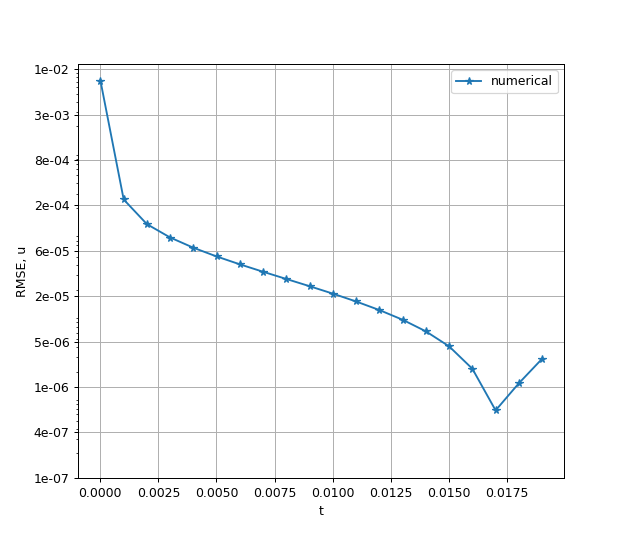

In [22]:
t_candid = range(1, len(t_test), 120)

errors = np.zeros((len(t_candid), 1))
for k, t in enumerate(t_candid):
	errors[k] = rmse(u_true[:, t:t+1], u_analytic[t])

import matplotlib.pyplot as plt
%matplotlib notebook

f, ax = plt.subplots(1, 1, figsize = (7, 6))
ax.semilogy(t_test[t_candid], errors, "-*", label = "numerical")

ax.set_xlabel("t")
ax.legend()
ax.grid()

yticks = [10**i for i in np.linspace(-7, -2, 10)]
ax.set_yticks(yticks)
ax.set_yticklabels(["{:.0e}".format(x) for x in yticks])
ax.set_ylabel("RMSE, u")
plt.show()